In [1]:
# import libraries
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# batch, classes, epochs
batch_size = 32
num_classes = 10
epochs = 10

In [3]:
# Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Pre-processing
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape(-1,32, 32, 3)  # reshaping for convnet

170500096/170498071 [==============================] - 4s 0us/step


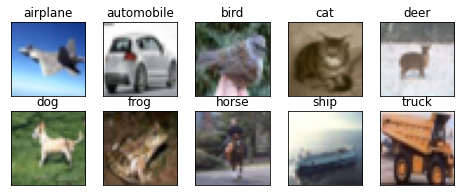

In [4]:
# plotting some random 10 images
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = (features_idx[img_num,::])
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [5]:
# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

##Base Model
First we will train our base model with a simple architecture

In [6]:
# model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [7]:
# summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

Let's then setup the loss, metrics, and the optimizer. The learning rate is also a hyperparameter you can tune automatically but for now, let's set it at 0.0001.

In [8]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# convert to float, normalise the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


In [9]:
# train 
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 38s 4ms/step - loss: 2.1603 - accuracy: 0.2100 - val_loss: 2.0340 - val_accuracy: 0.2793
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 2.0160 - accuracy: 0.2792 - val_loss: 1.9503 - val_accuracy: 0.3102
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.9396 - accuracy: 0.3094 - val_loss: 1.8636 - val_accuracy: 0.3335
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.8739 - accuracy: 0.3321 - val_loss: 1.8034 - val_accuracy: 0.3683
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.8175 - accuracy: 0.3513 - val_loss: 1.7540 - val_accuracy: 0.3804
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7768 - accuracy: 0.3656 - val_loss: 1.7129 - val_accuracy: 0.3953
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7470 - accuracy: 0.3761 - val_loss: 1.6775 - val_accuracy

In [10]:
model_result = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.6112 - accuracy: 0.4370


Result: After 10 epochs, the difference between training and validation accuracy is low but the training is slow as compared to the model with batch normalization.

In [11]:
# Install Keras Tuner
!pip install -q -U keras-tuner

     |████████████████████████████████| 102kB 5.8MB/s 


In [12]:
import kerastuner as kt
import keras

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


### Model Builder

In [13]:
def model_builder(hp):
  '''
  Builds the model and sets up the hyperparameters to tune.

  Args:
    hp - Keras tuner object

  Returns:
    model with hyperparameters to tune
  '''
  hp_filters=hp.Choice(
    'num_filters',
    values=[32, 64],
    default=64)
  
  hP_units=hp.Int(
      'units',
      min_value=32,
      max_value=512,
      step=32,
      default=128)
    
  '''hp_activation=hp.Choice(
        'dense_activation',
        values=['relu', 'tanh', 'sigmoid'],
        default='relu')'''

  hp_dropouts=hp.Choice(
    'dropout',
    values=[0.25, 0.35, 0.5])

# Initialize the Sequential API and start stacking the layers
  model = Sequential()
  
  # Tune the number of units in the first Dense layer
  model.add(
    Conv2D(hp_filters, kernel_size=3,activation='relu',input_shape=x_train.shape[1:]))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(rate=hp_dropouts))
  model.add(Conv2D(hp_filters, 3, activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(rate=hp_dropouts))
  model.add(Flatten())
  model.add(Dense(units=hP_units, activation='relu'))
  model.add(Dropout(rate=hp_dropouts))
  model.add(Dense(num_classes, activation='softmax'))
  # Choose an optimal value between 32-512
  
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.001, 0.0001, 0.00001 or 0.000001
  hp_learning_rate = hp.Choice('learning_rate', values=[ 1e-3, 1e-4, 1e-5,1e-6])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

  return model

In [14]:
# Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Pre-processing
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape(-1,32, 32, 3)  # reshaping for convnet

# Hyperband Tuner

In [15]:
# Instantiate the Tuner
hyperband_tuner = kt.Hyperband(
    model_builder,
    max_epochs=5,
    seed = 5,
    objective='val_accuracy',
    directory='hyperband',
    project_name='hyperband_cifar10'
)

####Arguments

- **hypermodel:** A HyperModel instance (or callable that takes hyperparameters and returns a Model instance).
-**objective:** A string or keras_tuner.Objective instance. If a string, the direction of the optimization (min or max) will be inferred.
-**max_epochs:** Integer, the maximum number of epochs to train one model. It is recommended to set this to a value slightly higher than the expected epochs to convergence for your largest Model, and to use early stopping during training (for example, via tf.keras.callbacks.EarlyStopping).
-**seed:** Optional integer, the random seed.
-**directory:** to save logs and checkpoints for every trial (model configuration) run during the hyperparameter search. If you re-run the hyperparameter search, the Keras Tuner uses the existing state from these logs to resume the search. To disable this behavior, pass an additional `overwrite=True` argument while instantiating the tuner.
-**project_name** to differentiate with other runs. This will be used as a subdirectory name under the `directory`.

Let's see a summary of the hyperparameters that you will tune:

In [16]:
# Display hypertuning settings
hyperband_tuner.search_space_summary()

Search space summary
Default search space size: 4
num_filters (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64], 'ordered': True}
units (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Choice)
{'default': 0.25, 'conditions': [], 'values': [0.25, 0.35, 0.5], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05, 1e-06], 'ordered': True}


You can pass in a callback to stop training early when a metric is not improving. Below, we define an EarlyStopping callback to monitor the validation loss and stop training if it's not improving after 5 epochs.

In [17]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

You will now run the hyperparameter search. The arguments for the search method are the same as those used for tf.keras.model.fit in addition to the callback above. This will take around 5 minutes to run.

In [18]:
# Perform hypertuning
hyperband_tuner.search(x_train, y_train, epochs=5, validation_split=0.2, callbacks=[stop_early])


Trial 10 Complete [00h 00m 41s]
val_accuracy: 0.2590999901294708

Best val_accuracy So Far: 0.675599992275238
Total elapsed time: 00h 03m 23s
INFO:tensorflow:Oracle triggered exit


You can get the top performing model with the `get_best_hyperparameters()` method.

In [19]:
# Get the optimal hyperparameters from the results
best_hps=hyperband_tuner.get_best_hyperparameters()[0]

print('Optimum no of filter for conv layer is {}'.format(best_hps.get('num_filters')))
print('Optimum no of units in Dense layer is {}'.format(best_hps.get('units')))
print('Optimun Dropout value is {}'.format(best_hps.get('dropout')))
print('Optimum learning rate value is {}'.format(best_hps.get('learning_rate')))

Optimum no of filter for conv layer is 32
Optimum no of units in Dense layer is 288
Optimun Dropout value is 0.25
Optimum learning rate value is 0.001


## Build and train the model

Now that you have the best set of hyperparameters, you can rebuild the hypermodel with these values and retrain it.

In [20]:
# Build the model with the optimal hyperparameters
h_model = hyperband_tuner.hypermodel.build(best_hps)
h_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

In [21]:
#training
h_model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.5436 - accuracy: 0.4403 - val_loss: 1.2472 - val_accuracy: 0.5566
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2412 - accuracy: 0.5597 - val_loss: 1.1266 - val_accuracy: 0.6081
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1122 - accuracy: 0.6104 - val_loss: 1.0641 - val_accuracy: 0.6310
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0314 - accuracy: 0.6364 - val_loss: 0.9447 - val_accuracy: 0.6714
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9643 - accuracy: 0.6604 - val_loss: 0.9121 - val_accuracy: 0.6893
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9185 - accuracy: 0.6777 - val_loss: 0.8644 - val_accuracy: 0.6991
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8805 - accuracy: 0.6900 - val_loss: 0.8402 - val_accuracy:

In [22]:
# evaluate the model on test data
h_model_result = h_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.8189 - accuracy: 0.7118


## Random Search

In [23]:
# Instantiate the Tuner
random_tuner = kt.RandomSearch(
    model_builder,
    objective = 'val_accuracy',
    max_trials = 5,
    seed=5,
    executions_per_trial=2,
    directory='random_search',
    project_name='randon_cifar10'
    
)

####Arguments

- **hypermodel:** A HyperModel instance (or callable that takes hyperparameters and returns a Model instance).
-**objective:** A string or keras_tuner.Objective instance. If a string, the direction of the optimization (min or max) will be inferred.
-**max_trials:** Integer, the total number of trials (model configurations) to test at most. Note that the oracle may interrupt the search before max_trial models have been tested if the search space has been exhausted.
-**seed:** Optional integer, the random seed.

In [24]:
random_tuner.search_space_summary()

Search space summary
Default search space size: 4
num_filters (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64], 'ordered': True}
units (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Choice)
{'default': 0.25, 'conditions': [], 'values': [0.25, 0.35, 0.5], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05, 1e-06], 'ordered': True}


In [25]:
# Perform hypertuning
random_tuner.search(x_train, y_train, epochs=5, validation_split=0.2, callbacks=[stop_early])


Trial 5 Complete [00h 00m 49s]
val_accuracy: 0.13539999723434448

Best val_accuracy So Far: 0.5745500028133392
Total elapsed time: 00h 05m 08s
INFO:tensorflow:Oracle triggered exit


In [26]:
# Get the optimal hyperparameters from the randomsearch results
rand_best_hps=random_tuner.get_best_hyperparameters()[0]

print('Random Search optimum no of filter for conv layer is {}'.format(rand_best_hps.get('num_filters')))
print('Random Search optimum no of units in Dense layer is {}'.format(rand_best_hps.get('units')))
print('Random Search optimun Dropout value is {}'.format(rand_best_hps.get('dropout')))
print('Random Search optimum learning rate value is {}'.format(rand_best_hps.get('learning_rate')))

Random Search optimum no of filter for conv layer is 64
Random Search optimum no of units in Dense layer is 416
Random Search optimun Dropout value is 0.35
Random Search optimum learning rate value is 0.0001


In [27]:
# Build the model with the optimal hyperparameters
r_model = random_tuner.hypermodel.build(rand_best_hps)
r_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

In [28]:
r_model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.8735 - accuracy: 0.3133 - val_loss: 1.6119 - val_accuracy: 0.4353
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5235 - accuracy: 0.4472 - val_loss: 1.4235 - val_accuracy: 0.5015
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3902 - accuracy: 0.5028 - val_loss: 1.2910 - val_accuracy: 0.5516
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3076 - accuracy: 0.5338 - val_loss: 1.2090 - val_accuracy: 0.5854
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2441 - accuracy: 0.5578 - val_loss: 1.1557 - val_accuracy: 0.6042
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1873 - accuracy: 0.5813 - val_loss: 1.1008 - val_accuracy: 0.6245
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1396 - accuracy: 0.5982 - val_loss: 1.0586 - val_accuracy:

In [29]:
r_model_results = r_model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.9681 - accuracy: 0.6710


## Bayesian Optimization


In [30]:
# Instantiate the Tuner
bayesian_tuner = kt.BayesianOptimization(
    model_builder,
    objective = 'val_accuracy',
    max_trials = 5,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    seed=5,
    directory='bayesian_optimization',
    project_name='bayesian_cifar10'
)

#### Arguments

- **hypermodel:** A HyperModel instance (or callable that takes hyperparameters and returns a Model instance).
-**objective:** A string or keras_tuner.Objective instance. If a string, the direction of the optimization (min or max) will be inferred.
-**max_trials:** Integer, the total number of trials (model configurations) to test at most. Note that the oracle may interrupt the search before max_trial models have been tested if the search space has been exhausted.
-**alpha:** Float, the value added to the diagonal of the kernel matrix during fitting. It represents the expected amount of noise in the observed performances in Bayesian optimization. Defaults to 1e-4.
-**beta:** Float, the balancing factor of exploration and exploitation. The larger it is, the more explorative it is. Defaults to 2.6.
-**seed:** Optional integer, the random seed.

In [31]:
bayesian_tuner.search_space_summary()

Search space summary
Default search space size: 4
num_filters (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64], 'ordered': True}
units (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Choice)
{'default': 0.25, 'conditions': [], 'values': [0.25, 0.35, 0.5], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05, 1e-06], 'ordered': True}


In [32]:
# Perform hypertuning
bayesian_tuner.search(x_train, y_train, epochs=5, validation_split=0.2, callbacks=[stop_early])


Trial 5 Complete [00h 00m 41s]
val_accuracy: 0.6488000154495239

Best val_accuracy So Far: 0.704200029373169
Total elapsed time: 00h 03m 19s
INFO:tensorflow:Oracle triggered exit


In [33]:
# Get the optimal hyperparameters from the randomsearch results
bayesian_best_hps=bayesian_tuner.get_best_hyperparameters()[0]

print('Bayesian Optimization optimum no of filter for conv layer is {}'.format(bayesian_best_hps.get('num_filters')))
print('Bayesian Optimization optimum no of units in Dense layer is {}'.format(bayesian_best_hps.get('units')))
print('Bayesian Optimization optimun Dropout value is {}'.format(bayesian_best_hps.get('dropout')))
print('Bayesian Optimization optimum learning rate value is {}'.format(bayesian_best_hps.get('learning_rate')))

Bayesian Optimization optimum no of filter for conv layer is 64
Bayesian Optimization optimum no of units in Dense layer is 512
Bayesian Optimization optimun Dropout value is 0.25
Bayesian Optimization optimum learning rate value is 0.001


In [34]:
# Build the model with the optimal hyperparameters
b_model = bayesian_tuner.hypermodel.build(bayesian_best_hps)
b_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

In [35]:
b_model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.4595 - accuracy: 0.4728 - val_loss: 1.1080 - val_accuracy: 0.6151
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1137 - accuracy: 0.6074 - val_loss: 0.9827 - val_accuracy: 0.6655
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9744 - accuracy: 0.6546 - val_loss: 0.9127 - val_accuracy: 0.6843
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8845 - accuracy: 0.6895 - val_loss: 0.8634 - val_accuracy: 0.7009
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8053 - accuracy: 0.7176 - val_loss: 0.8712 - val_accuracy: 0.7023
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7414 - accuracy: 0.7406 - val_loss: 0.7937 - val_accuracy: 0.7300
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6904 - accuracy: 0.7576 - val_loss: 0.7784 - val_accuracy:

In [36]:
b_model_results = b_model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.8122 - accuracy: 0.7365


In [69]:
print('Baseline Model Performance')
print('Loss:', round(model_result[0],2))
print('Accuracy:', round(model_result[1],2))
print('--------------------------------------------')
print('Model with HyperBand Tuner Performance')
print('Loss:', round(h_model_result[0],2))
print('Accuracy:', h_model_result[1])
print('--------------------------------------------')
print('Model with Random Search Tuner Performance')
print('Loss:', round(r_model_results[0],2))
print('Accuracy:', round(r_model_results[1],2))
print('--------------------------------------------')
print('Model with Bayesian Optimization Tuner Performance')
print('Loss:', round(b_model_results[0],2))
print('Accuracy:', round(b_model_results[1],2))
print('--------------------------------------------')


Baseline Model Performance
Loss: 1.61
Accuracy: 0.44
--------------------------------------------
Model with HyperBand Tuner Performance
Loss: 0.82
Accuracy: 0.7117999792098999
--------------------------------------------
Model with Random Search Tuner Performance
Loss: 0.97
Accuracy: 0.67
--------------------------------------------
Model with Bayesian Optimization Tuner Performance
Loss: 0.81
Accuracy: 0.74
--------------------------------------------
